<a href="https://colab.research.google.com/github/MMRES-PyBootcamp/MMRES-python-bootcamp2022/blob/main/13_Neural_Network101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, we are well-advised to use a GPU for substantial performance improvements.  
First we need to make sure we have a GPU available. Follow the following (this will restart your runtime).

![Open Runtime/change runtime](data/colab_GPU1.png)

![Choose GPU in hardware accelerator](data/colab_GPU2.png)

# Part I: Fully conected Neural Networks
In the introduction we got to know the basic fully-connected neural network architecture.  
We will revisit it later in our session about backpropagation more detail.  
Here, we first look at how to implement such a neural network in `torch` (or PyTorch),  
one of the leading automatic differentiation platforms for machine learning and AI.

Contemporary alternatives are [JAX](https://jax.readthedocs.io/en/latest/) and [TensorFlow](https://www.tensorflow.org/),  
which are backed by google and both have their advantages and disadvantages. All libraries are able to perform the tasks  
we are looking at, and it is solely a matter of preference which one we choose.

In [1]:
import torch
from torch import nn

/home/qottmann/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To build a neural network in (py)torch, you are expected to fill a "template" class  
that has a `__init__` and `forward` method. This varies for different machine learning  
frameworks, but the overall logic is the same.

In [3]:
in_dim = 28*28
out_dim = 10

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.neural_network = nn.Sequential(
            nn.Linear(in_dim, 512),  # input dimension, hidden1 dimension
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, 512),     # hidden1 dimension, hidden2 dimension
            nn.ReLU(),               # Non-linear activation function
            nn.Linear(512, out_dim), # hidden2 dimension, output dimension
        )

    def forward(self, x):
        x = self.flatten(x)          # input data preparation
        output = self.neural_network(x)
        return output

In [17]:
model = NeuralNetwork() #.to(device) uncomment for GPU execution
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (neural_network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For parallelization, PyTorch (and other ML frameworks) are built to process data in batches.  
Therefore, the input is always assumed to have the first dimension to be the `batch_size`.  
If we want to process a single input, we need to accont for a dummy dimension `batch_size=1`.  

In [18]:
try:
    X = torch.rand(in_dim)
    output = model(X) # results in an error
except:
    X = torch.rand(1, in_dim)
    output = model(X)

In [6]:
output.shape

torch.Size([1, 10])

E1: Due to the `flatten` function in the forward pass, the input is rather flexible, try inputting alternatively shaped tensors. What is the constraint that needs to be fulfilled?    
Here is one example:

In [7]:
X = torch.rand(1, 2, 14, 28)
model(X.to(device))

tensor([[ 0.0253,  0.1310,  0.0164,  0.0358, -0.1539, -0.0703, -0.0004,  0.1406,
          0.0619, -0.0693]], grad_fn=<AddmmBackward0>)

E2: We want the output of our NN to be the probability distribution for `out_dim = 7` different categories.  
Modify the network such that the output resembles a proper probability distribution, i.e. that 
$$\sum_{i=1}^\text{out_dim} p_i = 1$$ 
and $1\geq p_i \geq 0$

In [8]:
torch.isclose(torch.sum(model(X.to(device))), torch.tensor(1.))

tensor(False)

In [9]:
torch.all(model(X.to(device))>0)

tensor(False)

(Note that you can use most of the standard `numpy` functions in torch)  
Hint: Look up the so-called softmax function $\text{Softmax}: \mathbb{R}^m \mapsto \mathbb{R}^m$
$$
\left(\text{Softmax}(x)\right)_i = \frac{e^{x_i}}{\sum_{j=1}^m e^{x_j}}
$$
for $x \in \mathbb{R}^m$

# Part II: Backpropagation
We understand the _forward pass_ of a neural network, now it is time to learn how to optimize it. Curiosly, this is done in a similar fashion but in the reverse direction through a _backward pass_ via an algorithm called backpropagation. One of the big benefits of modern machine learning libraries like `torch` is they automatically perform this task for us. Still, we should know what is going on under the hood for a deeper understanding.


For this, we introduce the vector form of the forward pass in terms of the activation
$$a^\ell = f(z^\ell)$$
with weighted inputs
$$z^\ell = w^\ell a^{\ell-1} + b^\ell.$$
Note that all quantities are vectors, except for $w^\ell$, which is a matrix.  
The function $f$ may be different for each layer, though for simplicity we do not specify this explicitly.  
The over output of the network is given by
$$a^L = f(z^L) = f(w^L f(z^{L-1}) + b^L) =..,$$
a nested function of multiple activations and matrix multiplications.

One of many possible choices for a loss function is the $\ell^2$ norm
$$C = \frac{1}{2n} \sum_x ||y(x) - a^L(x)||^2.$$
Here, $a^L$ is the activation of the last layer, i.e. the NN output, and $y(x)$ is the label of the example $x$.  
For example, for binary classification (2 classes), $y(x)=(1,0)$ or $y(x)=(0,1)$, depending which class the example belongs to.

Our goal is it to minimize this loss function to achieve faithful predictions. This is done via so-called gradient descent.  
The idea is to change the trainable parameters of the neural network, $w$ and $b$, in the direction of steepest descent, which is exactly the gradient.  
We update the parameters according to
$$b^\ell \mapsto b^\ell - \alpha \nabla_{b^\ell} C$$
$$w^\ell \mapsto b^\ell - \alpha \nabla_{w^\ell} C$$
where $\alpha$ is a so-called hyper parameter, the learning rate, set by the user. This update rule is repeated many times until a minimum is reached.  
In practice we use more involved optimization routines that take  
the trajectory of past updates

We follow the derivation of the gradient of $C$ based on [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html) and find the equations for backpropagation:

$$\delta^L = \nabla_aC \odot f'(z^L)$$
$$\delta^\ell = \left((w^{\ell + 1})^T \delta^{\ell+1} \right) \odot f'(z^\ell)$$
$$\frac{\partial C}{\partial b^\ell_j} = \delta^\ell_j $$
$$\frac{\partial C}{\partial w^\ell_{jk}} = a^{\ell-1}_k \delta^\ell_j$$

Where in the case of the $\ell^2$ norm above, $\nabla_a C = \frac{1}{n} \sum_x \sum_i (y_i(x) - a_i(x))$.

Ex: For a forward pass with $x=(1,0)$,
$w^1 = \begin{pmatrix}
1 & 2 \\
1 & 2 \\
1 & 2 
\end{pmatrix}$, $w^2 = \begin{pmatrix}
-1 & -1 & -1\\
2 & 2 & 2
\end{pmatrix}$, $y=(1,0)$, and $f(x)=|x|$ (element-wise), compute $\frac{\partial}{\partial w^1_{1,1}} C$ and $\frac{\partial}{\partial w^1_{1,2}} C$

In [10]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [11]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [batch_size, color_channel, height, width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [batch_size, color_channel, height, width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [12]:
from matplotlib import pyplot as plt
import numpy as np

# technically you should not do the following because it defeats the purpose of having the data loader in the first place
test_data = list(test_dataloader)

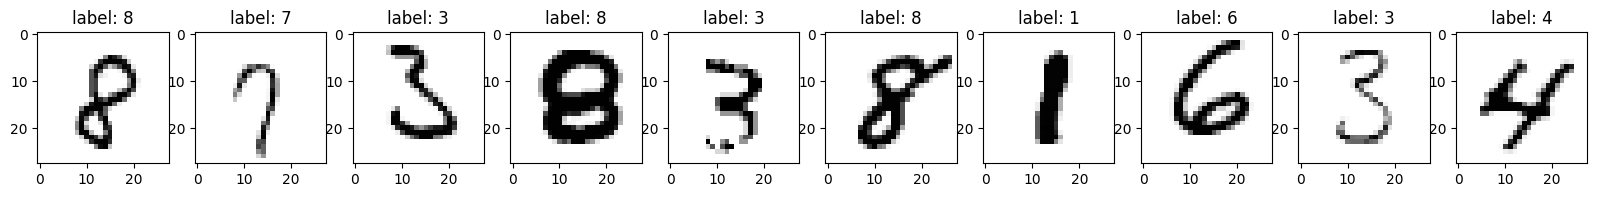

In [13]:
fig, axs = plt.subplots(ncols=10, figsize=(20, 4))
for i, pick in enumerate(np.random.randint(len(test_data),size=10)):
    ax = axs[i]
    ax.imshow(test_data[pick][0][0][0, :, :], cmap="Greys")
    ax.set_title(f"label: {test_data[pick][1][0]}")

Instead of the mean squared error loss, we are using the categorical cross entropy loss. The idea is the following.  
We want the output of the Neural Network to resemble the probability distribution $p(\text{label } y | x)$ (read: probability of label y, given example x).  
While the mean square error does also achieve notable success, there is a better measure to quantify the _distance_ between probability distributions,  
given by the so-called Kullback–Leibler divergence
$$D_\text{KL}(p || q) = \sum_i p_i \log(p_i/q_i).$$
We associate the distribution $p$ with the labels $y$ that are given by the dataset, and $q$ with the prediction of the neural network, that we now call $y^\text{NN}$.  

Upon close inspection and using the rules for logarithms $\log(x/y) = \log(x) - \log(y)$ you find that this can be re-written as
$$D_\text{KL}(y || y^\text{NN}) = \sum_i y_i (\log(y_i) - \log(y^\text{NN}_i)) = \sum_i y_i \log(y_i) - \sum_i y_i \log(y^\text{NN}_i).$$
We see that the left part of this quantity is independent of the network parameters, so any derivatives of it would be $0$.  
We therefore only take the right hand side as the loss function and define the so-called cross-entropy loss function
$$\text{CrossEntropyLoss} = - \sum_i y_i \log(y^\text{NN}_i)$$
Note that the label vector $y$ is always $1$ for the right category and $0$ everywhere else. So we are actually dealing, once again,  
minimizing the negative log likelihood $-\log(p(\text{label } y | x))$

Further, note that pytorch automatically applies a softmax to your NN output if you use `nn.CrossEntropyLoss()`, so there is no need to explicitly put it.  
Alternatively, you can use `nn.NLLLoss()` + `LogSoftmax` on the last layer (try it out and see if you get the same results for a random but fixed tensor).

In [14]:
loss_fn = nn.NLLLoss() # nn.CrossEntropyLoss() # nn.MSELoss() # mean squared error (MSE) loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # stochastic gradient descent (SGD) optimizer

So far we have ignored the GPU acceleration. We want to make use of it during training. For this we need to tell torch to load the tensors and models onto the GPU and execute it there (as opposed to natively on the CPU). This can be done via the `to(device)` method for tensors and models.

In [21]:
device = "cuda" # cuda is the name of the NVIDIA drivers for the GPU and have become synonymous with GPUs in the ML world.
model = model.to(device)

/home/qottmann/anaconda3/envs/test/lib/python3.8/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3050 Ti Laptop GPU with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3050 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # compute accuracy
    train_acc = correct/size * 100
    return loss, train_acc

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_acc = 100*correct
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, test_acc



In [16]:
epochs = 2
train_losss, train_accs = [], []
test_losss, test_accs = [], []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    train_losss.append(train_loss)
    train_accs.append(train_acc)
    test_losss.append(test_loss)
    test_accs.append(test_acc)
print("Done!")

Epoch 1
Test Error: Accuracy: 21.3%, Avg loss: -1.122009
Epoch 2
Test Error: Accuracy: 9.8%, Avg loss:      nan
Done!


In [ ]:
train_losss = torch.tensor(train_losss).cpu()
train_accs = torch.tensor(train_accs).cpu()
test_losss = torch.tensor(test_losss).cpu()
test_accs = torch.tensor(test_accs).cpu()

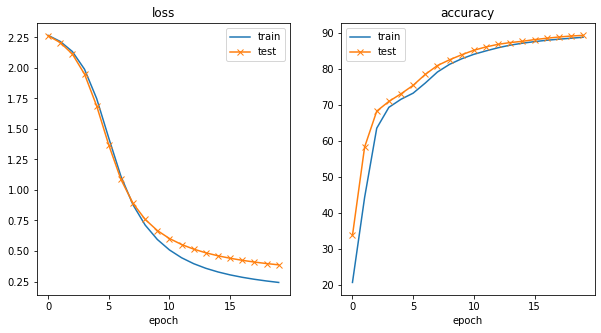

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
ax.plot(train_losss.cpu(), label="train")
ax.plot(test_losss.cpu(), "x-", label="test")

ax.set_title("loss")
ax.set_xlabel("epoch")
ax.legend()

ax = axs[1]
ax.plot(train_accs.cpu(), label="train")
ax.plot(test_accs.cpu(), "x-", label="test")

ax.set_title("accuracy")
ax.set_xlabel("epoch")
ax.legend()

Check the predictions manually

In [ ]:
model0 = model.to("cpu")

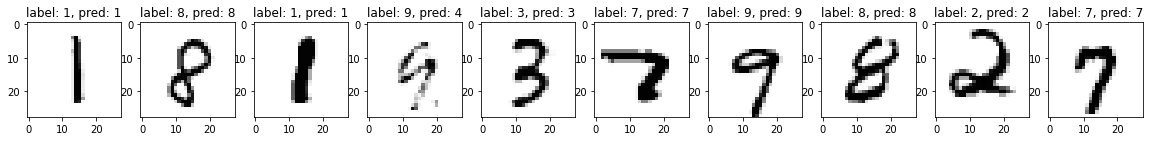

In [ ]:
fig, axs = plt.subplots(ncols=10, figsize=(20, 4))
for i, pick in enumerate(np.random.randint(len(test_data),size=10)):
    ax = axs[i]
    ax.imshow(test_data[pick][0][0][0, :, :], cmap="Greys")
    pred = model0(test_data[pick: pick+1][0][0][0]).argmax()
    ax.set_title(f"label: {test_data[pick][1][0]}, pred: {pred}")

Ex1: Compare performance using CPU vs GPU. You can use `time` or `datetime` for outputting the current time.  

Ex2: Further improve the training by using ADAM optimizer.